## Setup

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from ast import literal_eval
from random import choice
from xgboost import XGBRegressor, plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import Imputer

In [2]:
# declare paths
in_root = "../../data/main/"
out_root = "../../data/output/xgbooster/"

In [3]:
df = pd.read_csv(os.path.join(in_root, "train_test.csv"))
df.set_index(['id'], inplace=True)
labels = df.loc[:, ~df.columns.str.startswith('target_')].drop(['date'], axis=1).columns

In [4]:
target_name = "API"

## Loading Params

In [5]:
# xgboost hyperparams
with open(os.path.join(out_root, "params/", "params_" + target_name + ".txt"), 'r') as f:
    params = literal_eval(f.read())

## Baseline and Other Models

In [17]:
r2 = []
xgb_full, xgb_nodoy, xgb_nomerra2, linear, mlp = np.nan, np.nan, np.nan, np.nan, np.nan

In [18]:
for _ in range(10):
    
    # randomly sample
    station_id = choice(df.index.unique().tolist())
    print("Sampling {}...".format(station_id))
    # select station for train_test
    df_id = df.loc[station_id, :].copy()
    df_id = df_id[~pd.isna(df_id['target_' + target_name])]
    
    # FULL MODEL
    # slice data
    X = df_id.loc[:, ~df.columns.str.startswith('target_')].drop(
        ['date'], axis=1).values
    y = df_id['target_' + target_name].values
    # split to train/test
    split = int(X.shape[0] * 0.80)
    X, y = shuffle(X, y, random_state=42)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    # fit model
    m = XGBRegressor(**params)
    m.fit(X_train, y_train)
    xgb_full = r2_score(y_test, m.predict(X_test))
    
    # NO DOY
    # slice data
    X = df_id.loc[:, ~df.columns.str.startswith('target_')].drop(
        ['date', 'doy'], axis=1).values
    y = df_id['target_' + target_name].values
    # split to train/test
    split = int(X.shape[0] * 0.80)
    X, y = shuffle(X, y, random_state=42)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    # fit model
    m = XGBRegressor(**params)
    m.fit(X_train, y_train)
    xgb_nodoy = r2_score(y_test, m.predict(X_test))
    
    # NO MERRA2 POLLUTANT
    # slice data
    X = df_id.loc[:, ~df.columns.str.startswith('target_')].drop(
        ['date', 'AODANA', 'COSC', 'TO3'], axis=1).values
    y = df_id['target_' + target_name].values
    # split to train/test
    split = int(X.shape[0] * 0.80)
    X, y = shuffle(X, y, random_state=42)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    # fit model
    m = XGBRegressor(**params)
    m.fit(X_train, y_train)
    xgb_nomerra2 = r2_score(y_test, m.predict(X_test))
    
    # LINEAR REG
    # slice data
    X = df_id.loc[:, ~df.columns.str.startswith('target_')].drop(
        ['date'], axis=1).values
    y = df_id['target_' + target_name].values
    # split to train/test
    split = int(X.shape[0] * 0.80)
    X, y = shuffle(X, y, random_state=42)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    # impute mean
    imp = Imputer()
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)
    # fit model
    m = LinearRegression()
    m.fit(X_train, y_train)
    linear = r2_score(y_test, m.predict(X_test))
    
    # MLP
    # params
    mlp_params = {
        'alpha': 0.001,
        'hidden_layer_sizes': (128, 128),
        'learning_rate_init': 0.001,
        'verbose': False}
    # fit model
    m = MLPRegressor(**mlp_params)
    m.fit(X_train, y_train)
    mlp = r2_score(y_test, m.predict(X_test))
    
    r2.append([xgb_full, xgb_nodoy, xgb_nomerra2, linear, mlp])

Sampling 2531A...
Sampling 1965A...
Sampling 1381A...
Sampling 1302A...
Sampling 2603A...
Sampling 1323A...
Sampling 2249A...
Sampling 1240A...
Sampling 2668A...
Sampling 1716A...


In [19]:
r2 = pd.DataFrame(r2, columns=["xgb_full", "xgb_nodoy", "xgb_nomerra2", "linear", "mlp"])
r2

,xgb_full,xgb_nodoy,xgb_nomerra2,linear,mlp
0,0.573290,0.440446,0.575957,0.180536,0.212598
1,0.388318,0.325685,0.306428,0.256430,0.188120
2,0.718987,0.715651,0.642593,0.484527,0.465771
3,0.441175,0.414059,0.485211,0.311807,0.244653
4,0.625416,0.588799,0.607995,0.638005,-0.392679
5,0.398816,0.381020,0.385446,0.290766,0.223393
6,0.407783,0.398610,0.368552,0.311752,0.337931
7,0.535165,0.508986,0.525225,0.343591,0.128709
8,0.514280,0.350268,0.536415,0.259983,0.278658
9,0.496584,0.496478,0.456744,0.375071,0.343738


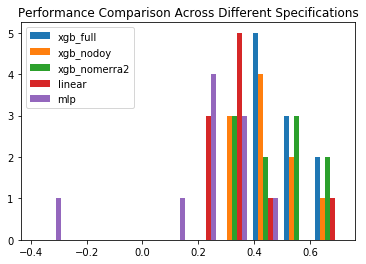

In [38]:
plt.hist(r2.values, histtype='bar', label=r2.columns.values.tolist())
plt.legend(prop={'size': 10})
plt.title("Performance Comparison Across Different Specifications")
plt.show()